In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import subprocess
import os
from tqdm import tqdm
import sys
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from neteval import performance_comparison as pc
sys.path.append("/cellar/users/snwright/Git/Network_Evaluation_Tools/")
import dev

/cellar/users/snwright/anaconda3/envs/pcnet_py3/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, HuberRegressor
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.cluster import SpectralBiclustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

plt.rcParams['svg.fonttype'] = 'none'

def cluster_matrix(mat, **kwargs):
	"""Function to cluster a matrix by rows and columns

	Args:
		mat (pandas.DataFrame): Matrix to cluster
		kwargs: Keyword arguments to pass to scipy.cluster.hierarchy.linkage
	Returns:
		pandas.DataFrame: Clustered matrix
	"""
	# Clustering on rows
	pairwise_distances_rows = sch.distance.pdist(mat.values)
	linkage_rows = sch.linkage(pairwise_distances_rows, **kwargs)
	cluster_distance_threshold_rows = pairwise_distances_rows.max()/2
	idx_to_cluster_array_rows = sch.fcluster(linkage_rows, cluster_distance_threshold_rows, criterion='distance')
	idx_rows = np.argsort(idx_to_cluster_array_rows)
	
	# Clustering on columns
	pairwise_distances_cols = sch.distance.pdist(mat.T.values)
	linkage_cols = sch.linkage(pairwise_distances_cols, **kwargs)
	cluster_distance_threshold_cols = pairwise_distances_cols.max()/2
	idx_to_cluster_array_cols = sch.fcluster(linkage_cols, cluster_distance_threshold_cols, criterion='distance')
	idx_cols = np.argsort(idx_to_cluster_array_cols)
	
	return mat.iloc[idx_rows, idx_cols]


def bicluster_matrix(mat, **kwargs):
	"""Function to bicluster a matrix using spectral biclustering
	args:
		mat (pandas.DataFrame): Matrix to bicluster
		kwargs: Keyword arguments to pass to sklearn.cluster.SpectralBiclustering
	returns:
		pandas.DataFrame: Biclustered matrix
	"""
	# Normalize the values to range from 0 to 1
	df_normalized = (mat - mat.min().min()) / (mat.max().max() - mat.min().min())

	# Perform spectral biclustering
	model = SpectralBiclustering(random_state=0, **kwargs)
	model.fit(df_normalized.values)

	# Rearrange the rows and columns of the DataFrame according to the biclusters
	mat_biclustered = mat.iloc[np.argsort(model.row_labels_)]
	mat_biclustered = mat_biclustered.iloc[:, np.argsort(model.column_labels_)]
	return mat_biclustered


def cluster_by_annot(df, annot_types, scale=False):
	"""Function to cluster a matrix by column annotation types. First clusters the high-level annotation 
	types, then clusters the columns within each high-level annotation type, 
	then clusters the rows across the whole matrix.

	args:
		df (pandas.DataFrame): Matrix to cluster
		annot_types (pandas.DataFrame): DataFrame with the same index as df and a single column 
			with the high-level annotation type for each column in df
		scale (bool): Whether to scale the values in df before clustering. Default is False.

	returns:
		pandas.DataFrame: Clustered matrix
	"""
	# If desired, standardize the values in the matrix
	if scale:
		scaler = StandardScaler()
		df_scaled = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
	else:
		df_scaled = df.copy()	
	# STEP 1: Cluster the high-level annotation types
	# first we want to order the high level annotation types:
	annot_type_means = df_scaled.groupby(annot_types.iloc[:,0], axis=1).mean()
	linkage_matrix_subtypes = linkage(pdist(annot_type_means.T, 'euclidean'), method='average')
	dendrogram_sub_types = dendrogram(linkage_matrix_subtypes, labels=annot_type_means.columns, no_plot=True)
	ordered_sub_types = dendrogram_sub_types['ivl']
	# STEP 2: Cluster the columns within each high-level annotation type
	#Extract the annotation types in the order they appear in input data
	df_annot_types = annot_types.loc[df.columns]
	# create a list to store the order of the diseases
	type_clusters = []
	# iterate over the high level classifications
	for sub_type in ordered_sub_types:
		# Get the samples in the current high level classification
		samps_in_type = df_annot_types[df_annot_types.iloc[:, 0] == sub_type].index
		df_subset = df_scaled[samps_in_type]
		# Calculate the distance matrix for the subset
		dist_matrix_subset = pdist(df_subset.T, 'cosine') # transpose because we want to cluster columns, not rows
		# Perform hierarchical clustering for the subset
		linkage_matrix_subset = linkage(dist_matrix_subset, method='average')
		# Generate dendrogram for subset
		dendrogram_subset = dendrogram(linkage_matrix_subset, labels=samps_in_type, no_plot=True)
		# Store the cluster order
		type_clusters.extend(dendrogram_subset['ivl'])
	# Create a DataFrame with the clustered high-level annotation types
	df_clustered_types = df_scaled[type_clusters]
	# STEP 3: Cluster the rows
	# Calculate the distance matrix for genes
	dist_matrix_genes = pdist(df_clustered_types, 'euclidean')
	# Perform hierarchical clustering for genes
	linkage_matrix_genes = linkage(dist_matrix_genes, method='average')
	# Generate dendrogram for genes
	dendrogram_genes = dendrogram(linkage_matrix_genes, labels=df_clustered_types.index, no_plot=True)
	# Get the gene order
	gene_clusters = dendrogram_genes['ivl']

	# Final DataFrame with clustered diseases and genes
	df_final = df_clustered_types.loc[gene_clusters]
	# Reorder the columns and rows in the original DataFrame according to the clustering
	row_idx = df_final.index
	col_idx = df_final.columns
	return df.loc[row_idx, col_idx]

class EvaluationResults:
	def __init__(self, eval_dir, prefix_file, metrics=["Performance", "Gain"], genesets=['disgen']):
		"""Class to store the results of evaluating a set of genesets against a set of networks

		Args:
			eval_dir (str): Path to directory containing evaluation results
			prefix_file (str): Path to file containing prefixes of networks to evaluate
			metrics (list, optional): The metric(s) to include from those generated in the 
				evaluation pipeline. Defaults to ["Performance", "Gain"].
			genesets (list, optional): The name(s) of the source of genesets used in the 
				evaluation pipeline. Defaults to ['disgen'].
		"""
		# make sure prefixes is in list form
		if type(prefix_file) == str:
			with open(prefix_file, 'r') as f:
				self.prefixes = [pref.strip() for pref in f.readlines()]
		else:
			self.prefixes = prefix_file
		# make sure metrics is in list form
		if type(metrics) == str:
			self.metrics = [metrics]
		else:
			self.metrics = metrics
		#make sure genesets is in list form
		if type(genesets) == str:
			self.genesets = [genesets]
		else:	
			self.genesets = genesets
		self.eval_dir = eval_dir
		self.results = {}
		# initialize the network name attribute
		self.network_names = {pref:pref for pref in self.prefixes}
		# load the results
		for metric in self.metrics:
			self.results[metric] = {}
			for geneset in self.genesets:
				self.results[metric][geneset] = self.load_evaluation_files(metric, geneset)
		
	def load_evaluation_files(self, use_metric, use_geneset):
		"""Function to load the evaluation files for a given metric and geneset. Uses
		the prefixes attribute to find the files. Displays files that fail to load.

		Args:
			use_metric (str): Metric to load
			use_geneset (str): Geneset to load

		Returns:
			pandas.DataFrame: DataFrame with the evaluation results
		"""
		# map metrics to the appropriate file suffixes
		paths = {'Performance': ["Performance/", '.performance.csv'], 
			"Gain": ["Performance_Gain/", ".performance_gain.csv"]}
		# get the list of files
		files = self.get_file_list(paths[use_metric][0],"."+use_geneset+ paths[use_metric][1])
		results_list = []
		# iterate over the files and try to load them, print file names if they fail
		for i, f in enumerate(files):
			try:
				df = pd.read_csv(f)
				df["Network"] = self.prefixes[i]
				results_list.append(df)
			except:
				print("FAILED:", f)
		# concatenate the results and pivot to get the correct format
		results = pd.concat(results_list).pivot(columns="Network", index="Unnamed: 0", values="0")
		results.index.name=None
		results.columns.name=None
		return results

	def get_file_list(self,metric, suff):
		"""Function to get a list of files for a given metric and suffix. Note this does not 
		check if the files exist.

		Args:
			metric (str): The metric to use
			suff (str): The suffix to use

		Returns:
			list: A list of file paths
		"""
		file_list = []
		for pref in self.prefixes:
			file_list.append(self.eval_dir+metric+pref+suff)
		return file_list

	def rank_all(self):
		"""Wrapper function to rank all networks for all metrics and genesets
		
		Returns:
			None
		"""
		ranks = {}
		# iterate over all availale metrics
		for metric in self.metrics:	
			# iterate over all available genesets
			for geneset in self.genesets:
				ranks[metric + "-" + geneset] = self.rank_networks(metric, geneset)
		# store the rankings in a DataFrame
		self.rankings = pd.DataFrame(ranks)

	def rank_networks(self, use_metric, use_geneset):
		"""Function to rank networks for a given metric and geneset

		Args:
			use_metric (str): The metric to use
			use_geneset (str): The geneset to use

		Returns:
			pandas.DataFrame: A DataFrame with the rankings
		"""
		# check if the metric and geneset are available
		if use_metric not in self.metrics:
			print("Metric not available")
			return
		if use_geneset not in self.genesets:
			print("Geneset not available")
			return
		# get the results for the given metric and geneset
		results = self.results[use_metric][use_geneset]
		# rank the networks
		rankings = results.rank(axis=1, ascending=False).mean(axis=0)
		return rankings
	
	def set_network_names(self, name_dict):
		"""Function to set the network names

		Args:	
			name_dict (dict): A dictionary with the network names

		Returns:	
			None
		"""
		for net in self.network_names:
			self.network_names[net] = name_dict[net]

	def plot_rank_scatter(self, metric, geneset, metric2=None, geneset2=None, axislabel1=None, axislabel2=None, labels=True, savepath=None):
		"""Compares the ranked network performance results of all networks for two sources of genesets for a given performance metric,
		or two performance metrics for a given source of genesets. Creates a scatter plot of the results. 

		Args:
			metric (str): The primary metric to use
			geneset (str): The primary geneset source to use
			metric2 (str, optional): The secondary metric for comparison across a single source of genesets. Defaults to None.
			geneset2 (str, optional): The secondary source of genesets for comparison across a single metric. Defaults to None.
			axislabel1 (str, optional): Axis label for primary metric/geneset soucre. Defaults to None (uses column name).
			axislabel2 (str, optional): Axis label for comparison metric/geneset source. Defaults to None (used column name).
			labels (bool, optional): Should the individual points be labeled with network names?. Defaults to True.
			savepath (str, optional): Full filepath for saving the figure to file. Defaults to None.

		Raises:
			ValueError: If both secondary metric and secondary geneset are specified, or if neither are specified.
		
		Returns:
			None
		"""
		# check if both secondary metric and secondary geneset are specified
		if metric2 is not None:
			if geneset2 is not None:
				raise ValueError("Can only specify two metrics or two genesets, not two of each")
			else:
				col1 = metric + "-" + geneset
				col2 = metric2 + "-" + geneset
		# check if neither secondary metric nor secondary geneset are specified
		else:
			if geneset is None:
				raise ValueError("Must specify either two metrics or two genesets to enable comparison")
			else:
				col1 = metric + "-" + geneset
				col2 = metric + "-" + geneset2
		# extract the necessary columns from the rankings DataFrame and plot
		_ = plt.figure(figsize=(7,7))
		ax = plt.gca()
		n = len(self.rankings)
		plot_df = self.rankings.loc[:, (col1, col2)]
		plot_df.plot(x=col1, y=col2, kind="scatter", ax=ax, s= 50)
		# add labels if specified
		if labels:
			_ = [plt.text(plot_df[col1][i], plot_df[col2][i], self.network_names[plot_df.index[i]], fontsize=7) for i in range(len(plot_df))]
		# add labels if specified
		if axislabel1 is not None:
			plt.xlabel(axislabel1, fontsize=14)
		if axislabel2 is not None:
			plt.ylabel(axislabel2, fontsize=14)
		# format the plot and save if specified
		plt.ylim((1, n))
		plt.xlim((1, n))
		ax.invert_yaxis()
		ax.invert_xaxis()
		ax.spines[['right', 'top']].set_visible(False)
		if savepath is not None:
			plt.savefig(savepath, dpi=600, bbox_inches="tight")

	def size_adjusted_performances(self, sizes, debug=False):
		"""Regress out network size from performance metrics

		Args:
			sizes (dict): Dictionary of network sizes
			debug (bool, optional): If True, randomly assign size variables. Defaults to False.

		Returns:
			None
		"""
		if debug:
			sizes = {net:[np.random.randint(1,100)] for net in self.prefixes}
		self.size_adjusted = {}
		self.sizes = sizes
		rankings = {}
		self.fits = {}
		# for each metric and geneset, regress out network size
		for metric in self.metrics:
			self.size_adjusted[metric] = {}
			self.fits[metric] = {}
			for geneset in self.genesets:
				results = self.results[metric][geneset]
				disease_residuals = {}
				fits = {}
				for disease in results.index:
					y = results.loc[disease]
					x = np.log10(np.array([sizes[net] for net in y.index]))
					if len(x.shape) == 1:
						x = x.reshape(-1,1)
					# perform a linear fit using Huber regression to account for outliers
					try:
						reg = HuberRegressor().fit(x, y)
					except ValueError:
						print("HuberRegression failed for " + metric + "-" + geneset + "-" + disease + ", using LinearRegression")
						reg = LinearRegression().fit(x, y)
					# calculate the residuals as the adjusted performance metric
					fits[disease] = (reg.coef_, reg.intercept_)
					disease_residuals[disease] = y - reg.predict(x) + reg.intercept_
				# save the residuals and fits
				self.size_adjusted[metric][geneset] = pd.DataFrame(disease_residuals).T
				self.fits[metric][geneset] = fits
				# re rank the data
				rankings[metric + "-" + geneset] = pd.DataFrame(disease_residuals).rank(axis=0, ascending=False).mean(axis=1)
		self.size_adjusted_rankings = pd.DataFrame(rankings)

	def plot_size_fit(self, metric, geneset, disease):
		"""Plot the fit of network size to performance metric for a specified disease geneset, 
		including the linear fit and the residuals

		Args:
			metric (str): The performance metric to plot
			geneset (str): The geneset source to plot
			disease (str): The disease to plot

		Returns:
			None
		"""
		# check that size_adjusted has been run and that the specified metric, geneset, and disease are available
		if metric not in self.size_adjusted:
			print("Metric not available")
			return
		if geneset not in self.size_adjusted[metric]:
			print("Geneset not available")
			return
		if disease not in self.size_adjusted[metric][geneset].index:
			print("Disease not available")
			return
		# get data
		raw_results = self.results[metric][geneset].loc[disease]
		if type(self.sizes[self.prefixes[0]]) == int:
			size_df= pd.DataFrame({"Size":self.sizes})
		elif (self.sizes[self.prefixes[0]]) == 1:
			size_df = pd.DataFrame({"Size":self.sizes})
			size_df['Size'] = size_df["Size"].apply(lambda x: x[0])
		else:
			raise NotImplementedError("Size adjustment plotting only implemented for single size per network")
		
		# get the results for plotting
		raw_results = pd.DataFrame({metric:raw_results}).join(size_df)
		size_results = self.size_adjusted[metric][geneset].loc[disease]
		size_results = pd.DataFrame({metric+"_adj":size_results}).join(size_df)

		# calculate the fit line from the fit parameters
		self._calculate_fit_line(metric, geneset, disease)
		fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
		sns.scatterplot(data=raw_results, x="Size", y=metric, ax=ax1)
		sns.scatterplot(data=size_results, x="Size", y=metric+"_adj", ax=ax2)
		fit_data = self._calculate_fit_line(metric, geneset, disease)
		sns.lineplot(data = fit_data, x="Size", y="Fit", ax=ax1, color="red")
		ax1.set_xscale("log")

	def _calculate_fit_line(self, metric, geneset, disease):
		"""Calculate the fit from the fit parameters and results

		Args:
			metric (str): The performance metric to plot
			geneset (str): The geneset source to plot
			disease (str): The disease to plot

		Returns:
			pandas.DataFrame: The fit line data
		"""
		# check that size_adjusted has been run and that the specified metric, geneset, and disease are available
		try:
			fit_coeffs = self.fits[metric][geneset][disease]
		except KeyError:
			print("Disease not available")
			return
		# extract the fit parameters
		intercept = fit_coeffs[1]
		coeffs = fit_coeffs[0]
		# initialize the dataframe
		fit_line_df = pd.DataFrame({'Size':self.sizes}) # this won't work for multiple size data points
		if type(self.sizes[self.prefixes[0]]) == list:
			fit_line_df["Size"] = fit_line_df["Size"].apply(lambda x: x[0])
		# calculate the fit line
		x = np.array([self.sizes[net] for net in fit_line_df.index])
		fit_line_df['Fit'] = np.multiply(np.log10(x), coeffs) + intercept
		fit_line_df = fit_line_df.sort_values(by="Size")
		return fit_line_df

	def plot_clustermap(self, metric, geneset, subset=None, network_subset=None, 
			n_subset=100, savepath=None, display_max=20, display_min=-5, 
			cluster_func=cluster_matrix, col_annot=None, row_annot=None, **cluster_kwargs):
		"""Plot a clustermap of the performance metric for each disease and network. Allows for
		subsetting of the genesets and networks to be plotted. Three clustering methods are
		available: `cluster_matrix` (hierarchical clustering of columns and rows), 
		`bicluster_matrix` (spectral biclustering for joint clustering of columns and rows), and
		`cluster_by_annot` (`cluster_matrix` while maintaining and ordering column groupings specified).

		Args:
			metric (str): The performance metric to plot
			geneset (str): The geneset source to plot
			subset (str or list, optional): Method for subsetting the genesets to be plotted. 
				One of "top","varaince", "quartile" to subset based on highest mean score, highest
				variance, or largest interquartile range of scores. A list of genesets to directly 
				specify. Defaults to None, all genesets plotted.
			network_subset (list, optional): Subset of networks to be plotted. Defaults to None.
			n_subset (int, optional): If the subset in ['top', 'variance', 'quartile'], 
				specifies the size of the subset. Defaults to 100.
			savepath (str, optional): Complete file path for saving the figure. Defaults to None.
			display_max (int, optional): Cap on the highest performance value to show in colormap. Defaults to 20.
			display_min (int, optional): Floor on the lowest performance value to show in the colormap. Defaults to -5.
			cluster_func (_type_, optional): Function to use for clustering. One of `cluster_matrix`,
				`bicluster_matrix`, or `cluster_by_annot`. Defaults to cluster_matrix.
			col_annot (pandas.DataFrame, optional): Dataframe specifying colors for annotating columns. Defaults to None.
			row_annot (pandas.DataFrame, optional): Dataframe specifying colors for annotating rows. Defaults to None.
			**cluster_kwargs: Additional keyword arguments to pass to the clustering function.
		Returns:
			None	
		"""
		# TODO legend for annotations
		result_df = self.results[metric][geneset]
		# perform subsetting
		if network_subset is not None:
			result_df = result_df.loc[:,network_subset]
		if subset is not None:
			result_df = self._subset_results(result_df, subset=subset, n_subset=n_subset)
		result_df.rename(columns=self.network_names, inplace=True)
		# get ordering of rows and columns from specified function
		clustered_results = cluster_func(result_df.T, **cluster_kwargs)
		# if no annotations, plot heatmap directly
		if (col_annot is None) and (row_annot is None):
			_, ax = plt.subplots(figsize=(10,10))
			sns.heatmap(clustered_results, cmap="RdBu", ax=ax, 
				center=0, vmin=display_min, vmax=display_max)
		# if annotations present, plot using clustermap with no clustering
		else:
			cg = sns.clustermap(clustered_results, row_cluster=False, col_cluster=False,
				cmap='RdBu', center=0, vmin=display_min, vmax=display_max,
				row_colors=row_annot, col_colors=col_annot, figsize=(10,15))
			ax = cg.ax_heatmap
		ax.set_xticks([])
		if savepath is not None:	
			plt.savefig(savepath, dpi=300, bbox_inches='tight')

	def plot_boxplot(self, metric, geneset, subset=None, network_subset=None, 
			n_subset=100, max_display=50, savepath=None, size_adjusted_metric=False):
		"""Plot a violin plot of the performance metric for each network. Allows for
		subsetting of the genesets and networks to be plotted. 

		Args:	
			metric (str): The performance metric to plot
			geneset (str): The geneset source to plot
			subset (str or list, optional): Method for subsetting the genesets to be plotted.
				One of "top","varaince", "quartile" to subset based on highest mean score, highest
				variance, or largest interquartile range of scores. A list of genesets to directly
				specify. Defaults to None, all genesets plotted.
			network_subset (list, optional): Subset of networks to be plotted. Defaults to None.
			n_subset (int, optional): If the subset in ['top', 'variance', 'quartile'],
				specifies the size of the subset. Defaults to 100.
			max_display (int, optional): Cap on the highest performance value to show in the plot. Defaults to 50.
			savepath (str, optional): Complete file path for saving the figure. Defaults to None.

		Returns:
			None
		"""
		if size_adjusted_metric:
			result_df = self.size_adjusted[metric][geneset]
		else:
			result_df = self.results[metric][geneset]
		# perform subsetting
		if network_subset is not None:
			result_df = result_df.loc[:,network_subset]
		if subset is not None:
			result_df = self._subset_results(result_df, subset=subset, n_subset=n_subset)
		# fromat the dataframe for plotting
		plot_df = result_df.melt(value_vars=result_df.columns, var_name="Network", value_name=metric).sort_values(by=metric, ascending=False)
		plot_df["Network"] = plot_df["Network"].apply(lambda x: self.network_names[x])
		# enforce the max display value
		plot_df[metric] = plot_df[metric].apply(lambda x: min(x, max_display))
		# sort the networks by median score
		plot_order = plot_df.groupby("Network").median().sort_values(by=metric, ascending=False).index.to_list()
		# plot the boxplot
		fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2,2*(len(plot_order)/10)))
		sns.boxplot(data=plot_df,y="Network", x=metric, linewidth=0.5,  fliersize=0.5, order=plot_order, color="lightgrey", 
			notch=True, ax=ax)
		# format the figure
		plt.ylabel("")
		plt.xlabel("Performance Score")
		ax.tick_params(axis='x', labelsize=9)
		ax.tick_params(axis='y', pad=0,labelsize=9)
		if savepath is not None:
			plt.savefig(savepath, dpi=300, bbox_inches='tight')

	def _subset_results(self, results, subset, n_subset):
		"""_summary_

		Args:
			results (panadas.DataFrame): The results dataframe to subset
			subset (str, or list): The method for subsetting the results. One of "top", "variance", 
				"quartile", or a list of genesets to subset.
			n_subset (int): If the subset is "top", "variance", or "quartile", the number 
				of genesets

		Returns:
			plot_results (pandas.DataFrame): The subsetted results dataframe
		"""
		if subset == "top": # subset based on mean score across networks
			subset_sets = results.mean(axis=1).sort_values(ascending=False)[:n_subset].index.to_list()
		elif subset == "variance": # subset based on high variance across networks
			subset_sets = results.var(axis=1).sort_values(ascending=False)[:n_subset].index.to_list()
		elif subset == "quartile": # subset based on high interquartile range across networks
			iqrs = results.quantile([0.25, 0.75], axis=1).T
			iqrs['IQR'] = iqrs[0.75] - iqrs[0.25]
			susbet_sets = iqrs.sort_values(by="IQR", ascending=False)[:n_subset].index.to_list()
		elif type(subset) == list: # subset based on a list of genesets
			subset_sets = subset
		plot_results = results.loc[subset_sets]
		return plot_results



In [63]:
eval_dir = "/cellar/users/snwright/Data/Network_Analysis/Evaluation/"
datadir = "/cellar/users/snwright/Data/Network_Analysis/Processed_Data/v2_2022/"
v1_file = "/cellar/users/snwright/Git/Network_Evaluation_Tools/Data/v1_net_prefixes.txt"
v2_file ="/cellar/users/snwright/Git/Network_Evaluation_Tools/Data/aim2_prefixes.txt"
gm_prefs=["GM_colocal", "GM_domain", "GM_physical", "GM_pathway", "GM_predicted", "GM_genetic_90"]

In [64]:
#v2_er = pc.EvaluationResults(eval_dir, v2_file, metrics=["Performance", "Gain"], genesets=['disgen', "cancer"])
v2_er = EvaluationResults(eval_dir, v2_file, metrics=["Performance", "Gain"], genesets=['disgen', "cancer"])


In [65]:
v2_er.rank_all()

In [66]:
v2_stats = dev.NetworkStats(v2_file, datadir )

In [67]:
v2_er.size_adjusted_performances(v2_stats.network_edge_counts)

In [68]:
v2_er.set_network_names(dev.load_network_names("/cellar/users/snwright/Git/Network_Evaluation_Tools/Data/network_names.txt"))

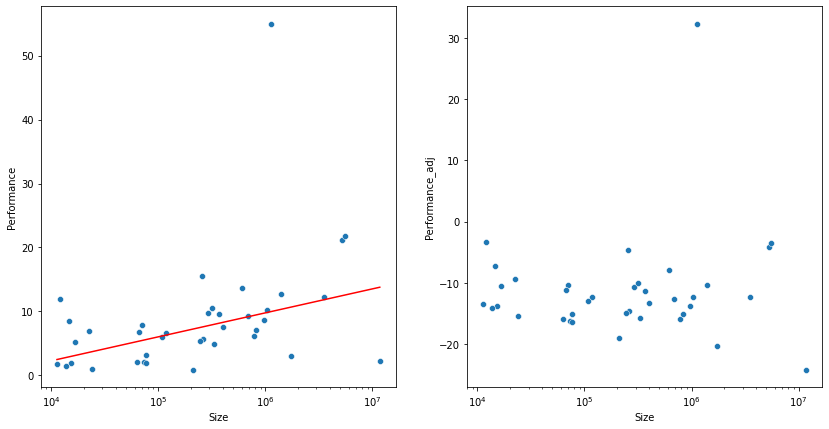

In [73]:
diseases = v2_er.results['Performance']['disgen'].index
v2_er.plot_size_fit('Performance', 'disgen', diseases[np.random.randint(0, 1240)])
plt.xscale("log")


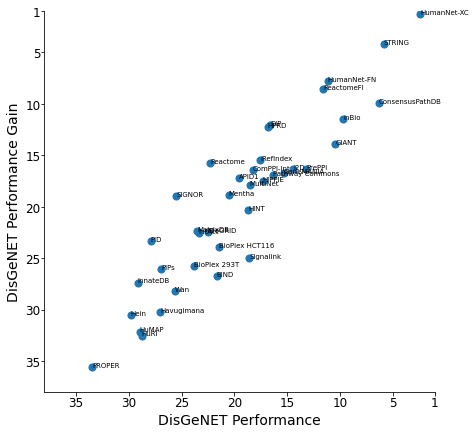

In [18]:
v2_er.plot_rank_scatter('Performance', 'disgen', metric2="Gain", savepath=None,labels=True,
                        axislabel1="DisGeNET Performance", axislabel2="DisGeNET Performance Gain")
ax = plt.gca()
ax.tick_params(labelsize=12, pad=0.5)
_ = plt.xticks([35, 30, 25, 20, 15, 10, 5, 1])
_ = plt.yticks([35, 30, 25, 20, 15, 10, 5, 1])
plt.savefig("/cellar/users/snwright/Data/Transfer/pcnet/figures/Perf_Gain_Rank.svg", bbox_inches='tight', dpi=400)

In [10]:
df = v2_er.results["Performance"]['disgen']

In [11]:
df = df.melt(var_name="Network", value_name='Performance')

In [12]:
plot_df = pd.concat([df.groupby("Network").median(), df.groupby("Network").quantile(0.25), df.groupby("Network").quantile(0.75)], axis=1)
plot_df.columns = ['Median', 'Low', 'High']
plot_df = plot_df.join(pd.DataFrame({'netSize':v2_stats.network_edge_counts}))

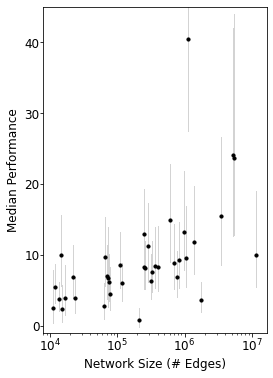

In [96]:
_ = plt.figure(figsize=(4,6))
plt.scatter(plot_df.netSize, plot_df.Median, c='k', s=10, zorder=10)
for i in range(plot_df.shape[0]):
    plt.plot([plot_df.netSize[i], plot_df.netSize[i]], [plot_df.Low[i], plot_df.High[i]], c='lightgrey', lw=1)
plt.xscale("log")
plt.ylim(-1, 45)
plt.xlabel("Network Size (# Edges)", fontsize=12)
plt.ylabel("Median Performance", fontsize=12)
ax = plt.gca()
ax.tick_params(labelsize=12, pad=0.5)
plt.savefig("/cellar/users/snwright/Data/Transfer/pcnet/figures/Perf_vs_Size.svg", bbox_inches='tight', dpi=400)

## Is the relationship between size and performance linear?

In [9]:
sizes = {pref:np.array([np.log10(node_counts[pref]), np.log10(edge_counts[pref])]) for pref in v2_er.prefixes}
sizes = {pref:np.array([np.log10(edge_counts[pref])]) for pref in v2_er.prefixes}

In [10]:
v2_er.size_adjusted_performances(sizes)

In [11]:
perf_df = v2_er.rankings.join(pd.DataFrame({"Edges":edge_counts}))
adj_df = v2_er.size_adjusted_rankings.join(pd.DataFrame({"Edges":edge_counts}))

In [12]:
perf_df.head()

,Performance-disgen,Performance-cancer,Gain-disgen,Gain-cancer,Edges
apid.0,20.649278,22.179104,19.190209,19.179104,584516
apid.1,21.245586,18.373134,18.614767,14.686567,261073
apid.2,21.932584,16.955224,21.674157,16.865672,131342
bind.v8,23.604334,27.358209,29.211075,29.253731,72715
biogrid.4.4.217,24.504815,23.880597,24.682986,20.985075,784297


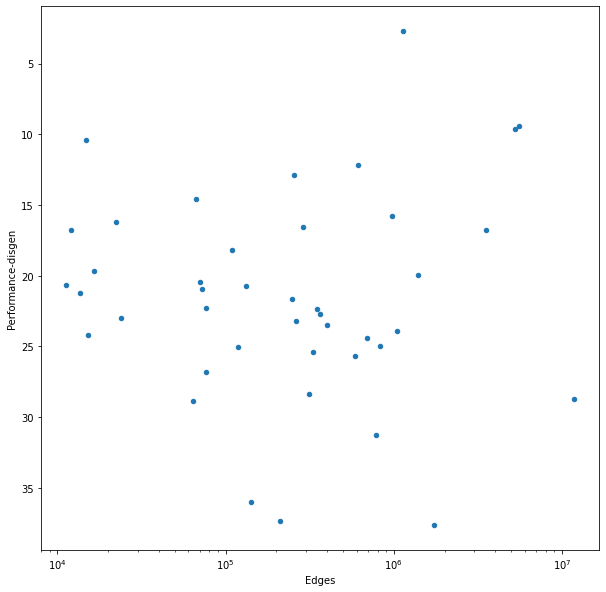

In [13]:
adj_df.plot(kind='scatter', x='Edges', y='Performance-disgen', logx=True, logy=False, figsize=(10,10))
ax = plt.gca()
ax.invert_yaxis()

In [19]:
diseases = v2_er.results['Performance']['disgen'].index

In [22]:
diseases = v2_er.results['Performance']['disgen'].index
v2_er.plot_size_fit('Performance', 'disgen', diseases[np.random.randint(0, 1240)])

KeyError: 'Brain Infarction'

In [112]:
v2_er.results['Performance']['disgen'].loc["AIDS related complex"]

apid.1                    5.131169
bind.v8                   1.928718
biogrid.4.4.217           6.012560
bioplex.v3.293T           2.247423
bioplex.v3.HCT116         7.338296
comppi_interactions       3.397887
consensus_db.v35          9.516778
dip.PC                   10.408096
genemania.2021            2.165446
giant_90                  9.143546
havugimana               -0.936742
hein                      3.586193
hi.union                 13.537196
hint.updated.combined     4.412196
hippie.2.3                5.644477
hprd                     13.101092
humannet.v3.fn            8.033036
humannet.v3.xc           41.846803
humap_90                  2.273754
i2d                       5.623483
inbio                    11.872424
innatedb_all              1.472225
intact.243                5.577753
irefindex.v19             6.989636
matrixdb                  2.695288
mentha.23.1.2             2.790029
multinet                  5.609930
pathway_commons.12        9.684583
pid.12              

## Previous stuff

In [17]:
with open("/cellar/users/snwright/Git/Network_Evaluation_Tools/Data/v1_net_prefixes.txt", 'r') as f:
    v1_prefixes = [pref.strip() for pref in f.readlines()]
for net in ["original_data_sets/v1_composite_min2", "original_data_sets/pcnet_v1.4"]:
    v1_prefixes.append(net)

with open("/cellar/users/snwright/Git/Network_Evaluation_Tools/Data/v2_net_prefixes.txt", 'r') as f:
    v2_prefixes = [pref.strip() for pref in f.readlines()]
v2_prefixes.append("v2_composite_min2")

In [18]:
v2_prefixes = ["GM_colocal", "GM_domain", "GM_physical", "GM_pathway", "GM_predicted", "GM_genetic_90"]

In [19]:
def get_file_list(prefs, datadir, suff):
    file_list = []
    for pref in prefs:
        file_list.append(datadir+pref+suff)
    return file_list


def load_evaluation_files(pref, eval_dir, metric='Performance', geneset="disgen_orig"):
    paths = {'Performance': ["Performance/", '.performance.csv'], 
            "Gain": ["Performance_Gain/", ".performance_gain.csv"]}
    files = get_file_list(pref, eval_dir+paths[metric][0],"."+geneset+ paths[metric][1])
    results_list = []
    for i, f in enumerate(files):
        try:
            df = pd.read_csv(f)
            df["Network"] = pref[i]
            results_list.append(df)
        except:
            print("FAILED:", f)
    results = pd.concat(results_list).pivot(columns="Network", index="Unnamed: 0", values="0")
    results.index.name=None
    results.columns.name=None
    return results

def rank_networks(scores):
    # sort in descending order
    order = scores.sort_values(ascending=False)
    return {order.index[i]: i+1 for i, _ in enumerate(order)}

def average_network_rank(result_df):
    ranks = {}
    for geneset in result_df.index:
        ranks[geneset] = rank_networks(result_df.loc[geneset])
    rank_df = pd.DataFrame.from_dict(ranks).T
    mean_rank = rank_df.apply(np.mean, axis=0)
    return mean_rank, rank_df
    

## DisGenNET Original

In [20]:
disgen_perf = load_evaluation_files(v2_prefixes, eval_dir, "Performance", geneset="disgen")
disgen_ranks, _ = average_network_rank(disgen_perf)

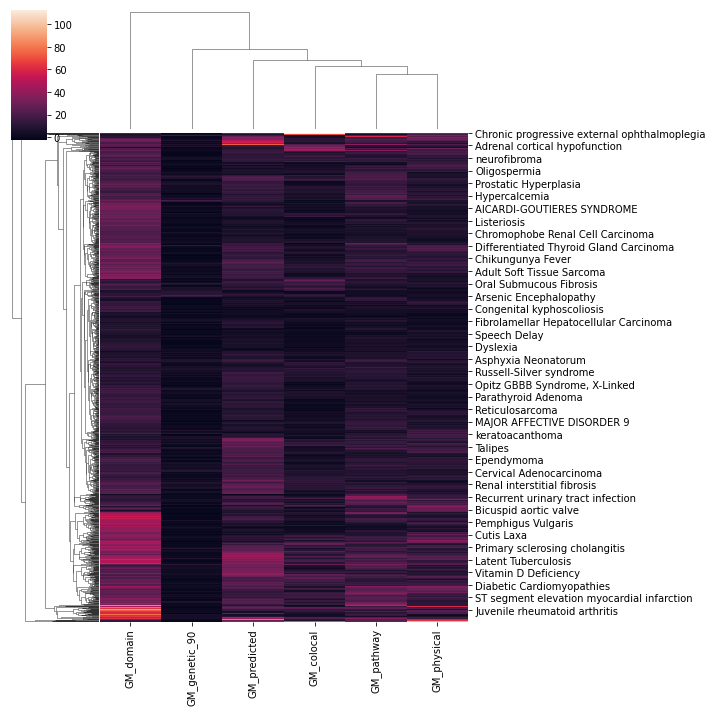

In [21]:
sns.clustermap(disgen_perf)
plt.savefig("/cellar/users/snwright/Data/Transfer/pcnet/figures/GM_performance.png", dpi=400, bbox_inches="tight")

In [22]:
disgen_gain = load_evaluation_files(v2_prefixes, eval_dir, "Gain", geneset="disgen")
disgen_gain_ranks, _ = average_network_rank(disgen_gain)

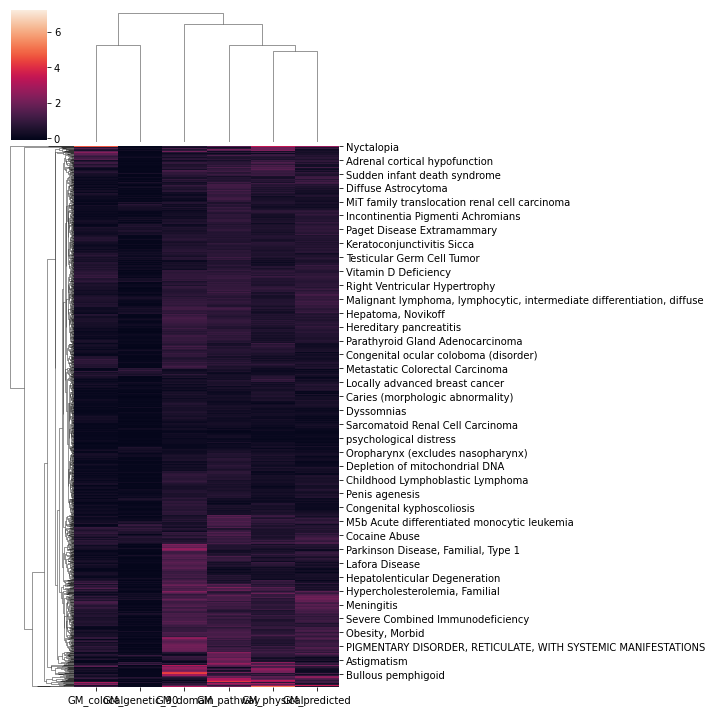

In [23]:
sns.clustermap(disgen_gain)


In [24]:
disgen_perf_v1 = load_evaluation_files(v1_prefixes, eval_dir, "Performance")
disgen_ranks_v1, _ = average_network_rank(disgen_perf_v1)
sns.clustermap(disgen_perf_v1)

FAILED: /cellar/users/snwright/Data/Network_Analysis/Evaluation/Performance/bind.v8.disgen_orig.performance.csv
FAILED: /cellar/users/snwright/Data/Network_Analysis/Evaluation/Performance/giant_90.disgen_orig.performance.csv
FAILED: /cellar/users/snwright/Data/Network_Analysis/Evaluation/Performance/hprd.disgen_orig.performance.csv
FAILED: /cellar/users/snwright/Data/Network_Analysis/Evaluation/Performance/inbio.disgen_orig.performance.csv
FAILED: /cellar/users/snwright/Data/Network_Analysis/Evaluation/Performance/multinet.disgen_orig.performance.csv
FAILED: /cellar/users/snwright/Data/Network_Analysis/Evaluation/Performance/original_data_sets/biogrid.3.4.149.disgen_orig.performance.csv
FAILED: /cellar/users/snwright/Data/Network_Analysis/Evaluation/Performance/original_data_sets/bioplex.v2.disgen_orig.performance.csv
FAILED: /cellar/users/snwright/Data/Network_Analysis/Evaluation/Performance/original_data_sets/consensus_db.v32.disgen_orig.performance.csv
FAILED: /cellar/users/snwright

ValueError: No objects to concatenate

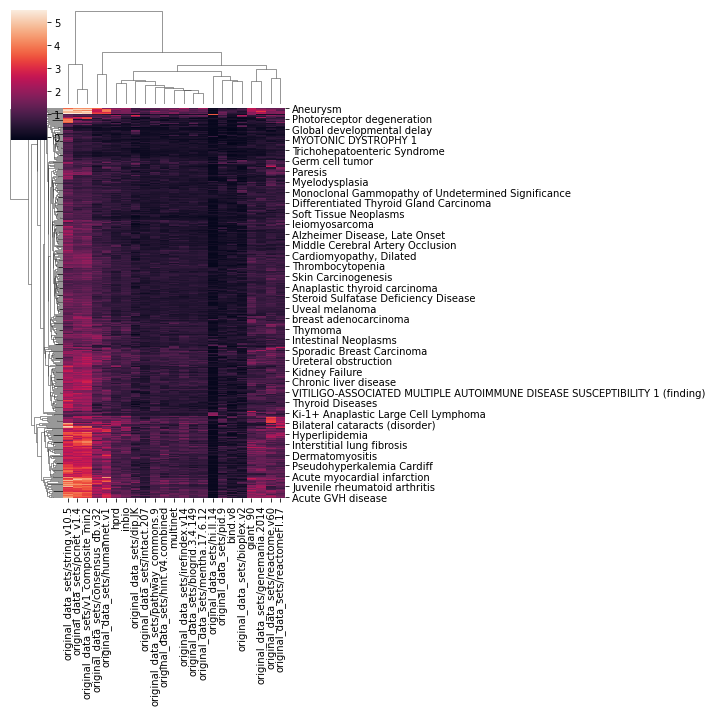

In [ ]:
disgen_gain_v1 = load_evaluation_files(v1_prefixes, eval_dir, "Gain")
disgen_gain_ranks_v1, _ = average_network_rank(disgen_gain_v1)
sns.clustermap(disgen_gain_v1)

## GWAS Original

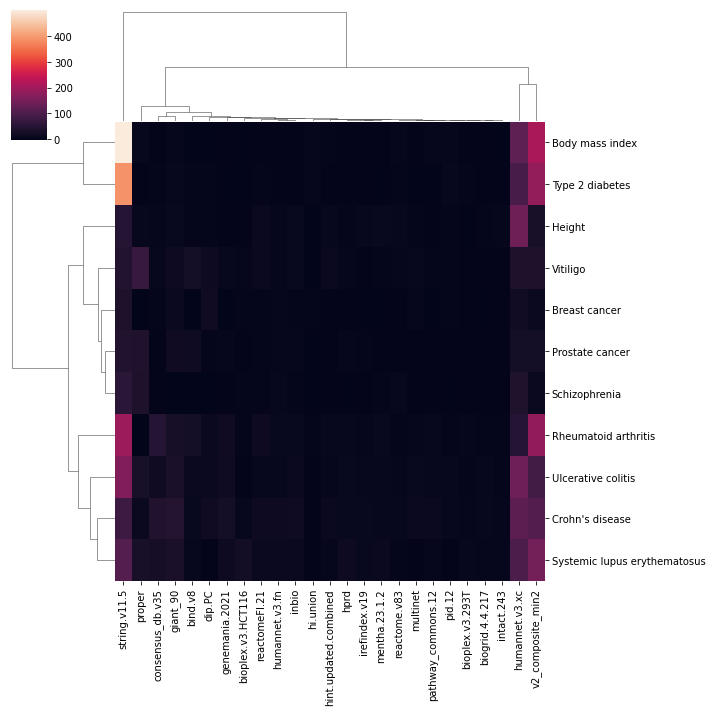

In [ ]:
gwas_perf = load_evaluation_files(v2_prefixes, eval_dir, "Performance", geneset="gwas_orig")
gwas_ranks, _ = average_network_rank(gwas_perf)
sns.clustermap(gwas_perf)

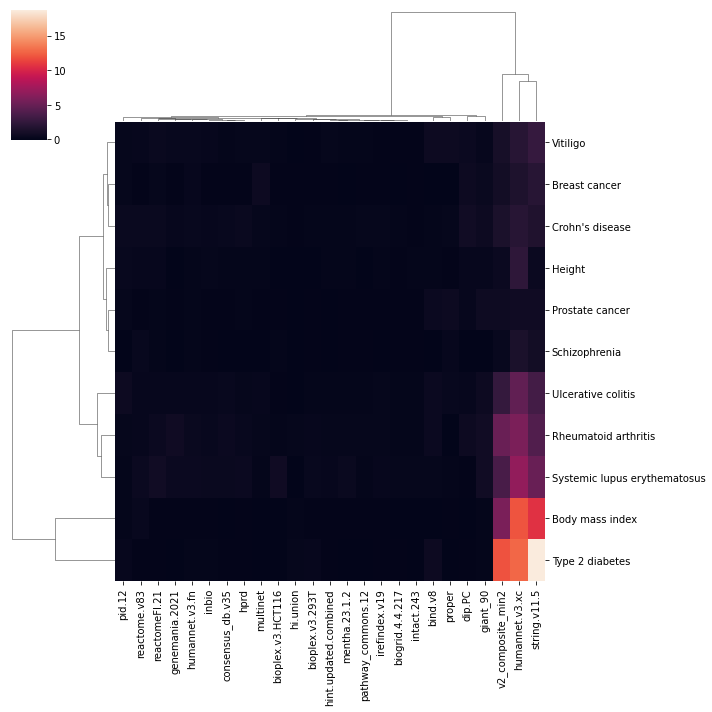

In [ ]:
gwas_gain = load_evaluation_files(v2_prefixes, eval_dir, "Gain", geneset="gwas_orig")
gwas_gain_ranks, _ = average_network_rank(gwas_gain)
sns.clustermap(gwas_gain)

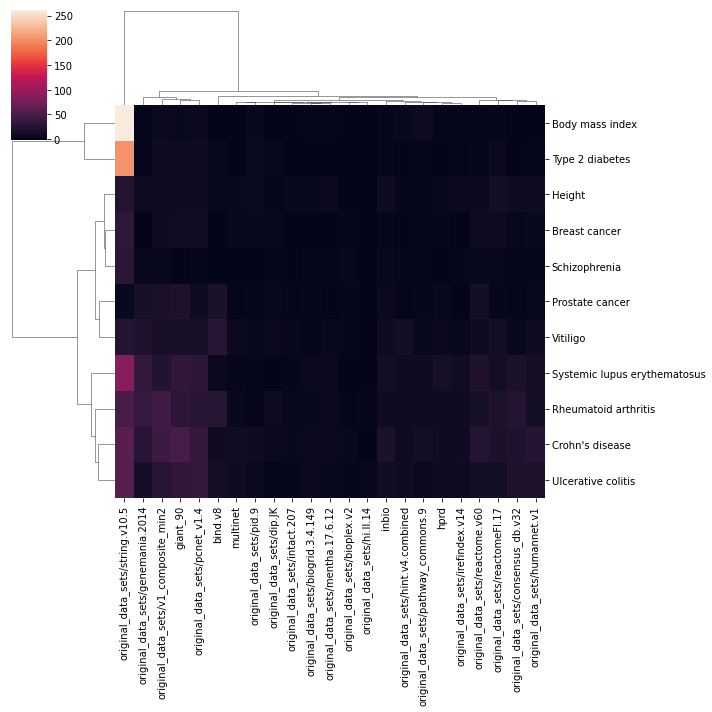

In [ ]:
gwas_perf_v1 = load_evaluation_files(v1_prefixes, eval_dir, "Performance", geneset="gwas_orig")
gwas_ranks_v1, _ = average_network_rank(gwas_perf_v1)
sns.clustermap(gwas_perf_v1)

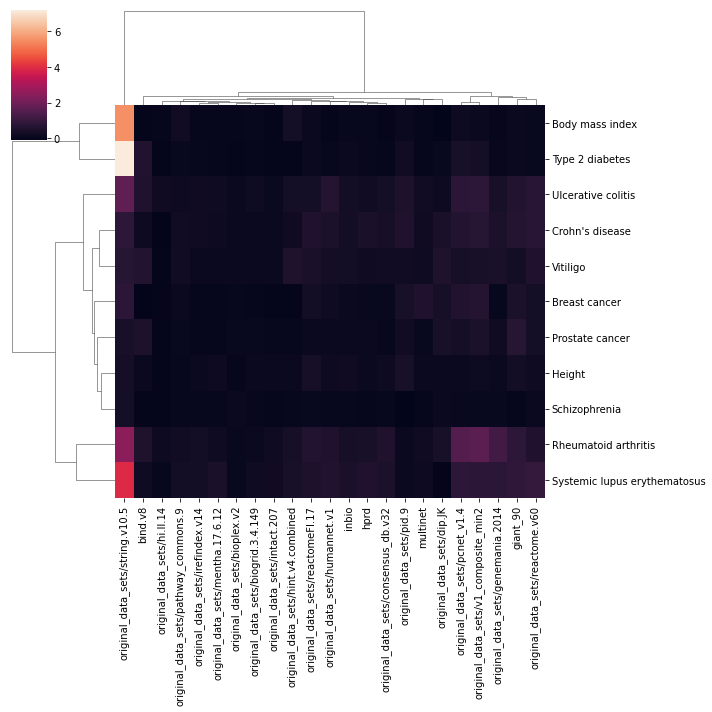

In [ ]:
gwas_gain_v1 = load_evaluation_files(v1_prefixes, eval_dir, "Gain", geneset="gwas_orig")
gwas_gain_ranks_v1, _ = average_network_rank(gwas_gain_v1)
sns.clustermap(gwas_gain_v1)

## Network Ranks

### Disgen Original

In [ ]:
def plot_rank_scatter(rank1, rank2, rank1_name="Literature Gene Sets", rank2_name="GWAS Gene Sets", metric="Performance Score", labels=True, savepath=None):
    _ = plt.figure(figsize=(7,7))
    ax = plt.gca()
    n = len(rank1)
    v2_perf = pd.concat([rank1, rank2], axis=1)
    v2_perf.columns = [rank1_name, rank2_name]
    v2_perf = n - v2_perf
    v2_perf.plot(x=rank1_name, y=rank2_name, kind="scatter", ax=ax, s= 50)
    if labels:
        for i in range(len(v2_perf)):
            plt.annotate(v2_perf.index[i], (v2_perf[rank1_name][i], v2_perf[rank2_name][i]), fontsize=7)
    _ = plt.xticks([i+1 for i in range(n)], labels=[n-i for i in range(n)])
    _ = plt.yticks([i+1 for i in range(n)], labels=[n-i for i in range(n)])
    plt.xlabel(rank1_name + " - " + metric, fontsize=14)
    plt.ylabel(rank2_name + " - "+ metric, fontsize=14)
    plt.ylim((1, n))
    plt.xlim((1, n))
    ax.spines[['right', 'top']].set_visible(False)
    if savepath is not None:
        plt.savefig(savepath, dpi=600, bbox_inches="tight")

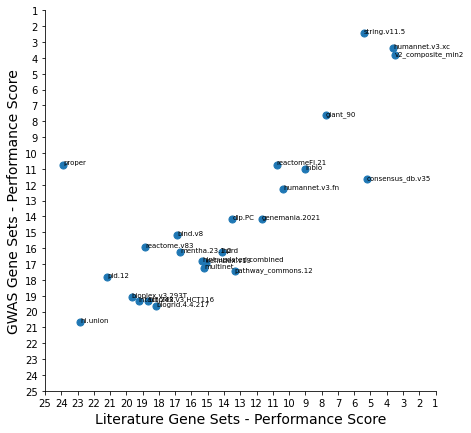

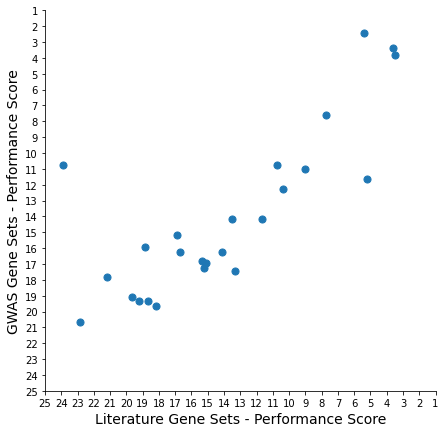

In [ ]:
plot_rank_scatter(disgen_ranks, gwas_ranks, savepath="/cellar/users/snwright/Data/Transfer/pcnet/figures/v2_original_ranks_labelled.png")
plot_rank_scatter(disgen_ranks, gwas_ranks, labels=False, savepath="/cellar/users/snwright/Data/Transfer/pcnet/figures/v2_original_ranks.png")

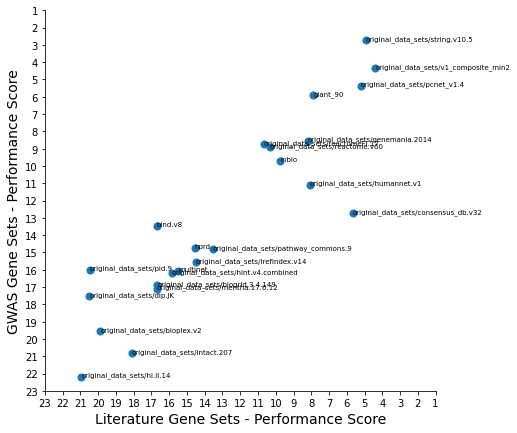

In [ ]:
plot_rank_scatter(disgen_ranks_v1, gwas_ranks_v1)

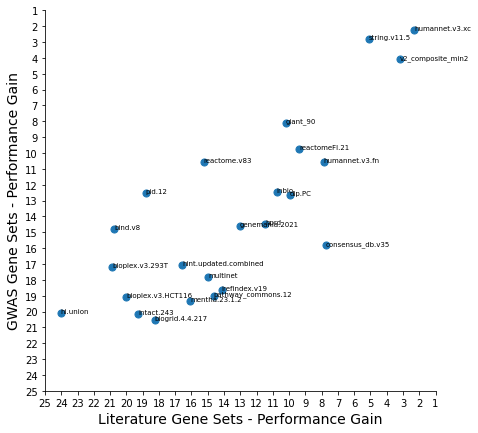

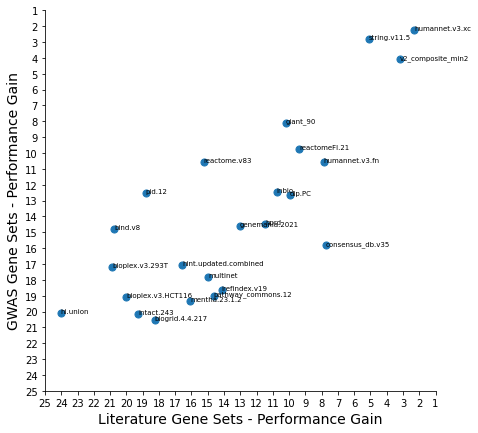

In [ ]:
plot_rank_scatter(disgen_gain_ranks, gwas_gain_ranks, metric="Performance Gain", savepath="/cellar/users/snwright/Data/Transfer/pcnet/figures/v2_original_ranks_gain_labelled.png")
plot_rank_scatter(disgen_gain_ranks, gwas_gain_ranks, metric="Performance Gain", savepath="/cellar/users/snwright/Data/Transfer/pcnet/figures/v2_original_ranks_gain.png")

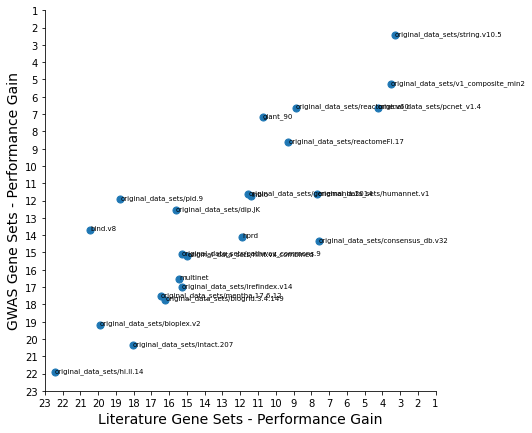

In [ ]:
plot_rank_scatter(disgen_gain_ranks_v1, gwas_gain_ranks_v1, metric="Performance Gain")

### Ranks old vs new

In [ ]:
def old_vs_new_comparison(v1_prefixes, v2_prefixes, data1, data2):
    stripped_v2_prefs = pd.DataFrame.from_dict({pref:pref.split(".")[0] for pref in v2_prefixes}, orient="index")
    stripped_v1_prefs = [pref for pref in v1_prefixes if "original" in pref]
    stripped_v1_prefs = pd.DataFrame.from_dict({pref: pref.split("original_data_sets/")[1].split(".")[0] for pref in stripped_v1_prefs}, orient="index")
    new_df = pd.concat([stripped_v2_prefs, data2], axis=1).reset_index(drop=True)
    new_df.columns = ["network", "v2"]
    old_df = pd.concat([stripped_v1_prefs, data1], axis=1).dropna().reset_index(drop=True)
    old_df.columns = ["network", "v1"]
    df = new_df.merge(old_df, on="network", how="inner")
    return df

In [ ]:
disgen_rank_comp = old_vs_new_comparison(v1_prefixes, v2_prefixes, disgen_ranks_v1, disgen_ranks)
gwas_rank_comp = old_vs_new_comparison(v1_prefixes, v2_prefixes, gwas_ranks_v1, gwas_ranks)
disgen_gain_rank_comp = old_vs_new_comparison(v1_prefixes, v2_prefixes, disgen_gain_ranks_v1, disgen_gain_ranks)
gwas_gain_rank_comp = old_vs_new_comparison(v1_prefixes, v2_prefixes, gwas_gain_ranks_v1, gwas_gain_ranks)


In [ ]:
def plot_rank_comparison(score_df, n1, n2, labels=True, metric="Performance Score", savepath=None):
    _ = plt.figure(figsize=(6,6))
    ax = plt.gca()
    comp_df = score_df.copy()
    comp_df["v2"] = n1 - (comp_df["v2"] * n1/n2)
    comp_df["v1"] = n1 - comp_df["v1"]
    comp_df.plot(x="v1", y="v2", kind="scatter", ax=ax, s=50)
    if labels:
        for i in range(len(comp_df)):
            plt.annotate(comp_df.network[i], (comp_df["v1"][i], comp_df["v2"][i]), fontsize=7)
    _ = plt.xticks([i+1 for i in range(n1)], labels=[n1-i for i in range(n1)])
    _ = plt.yticks([i+1 for i in range(n1)], labels=[n1-i for i in range(n1)])
    plt.xlabel("v1" + " - " + metric, fontsize=14)
    plt.ylabel("v2" + " - "+ metric, fontsize=14)
    
    plt.ylim((1, n1))
    plt.xlim((1, n1))
    ax.spines[['right', 'top']].set_visible(False)
    if savepath is not None:
        plt.savefig(savepath, dpi=600, bbox_inches="tight")
        
def plot_performance_comparison(score_df, labels=True, metric="Performance Score", savepath=None):
    _ = plt.figure(figsize=(6,6))
    ax = plt.gca()
    comp_df = score_df.copy()
    comp_df.plot(x="v1", y="v2", kind="scatter", ax=ax, s=50)
    if labels:
        for i in range(len(comp_df)):
            plt.annotate(comp_df.network[i], (comp_df["v1"][i], comp_df["v2"][i]), fontsize=7)
    plt.xlabel("v1" + " - " + metric, fontsize=14)
    plt.ylabel("v2" + " - "+ metric, fontsize=14)
    plt.axline(xy1=(0, 0), slope=1, color="black", linestyle="--", linewidth=0.5)
    ax.spines[['right', 'top']].set_visible(False)
    if savepath is not None:
        plt.savefig(savepath, dpi=600, bbox_inches="tight")

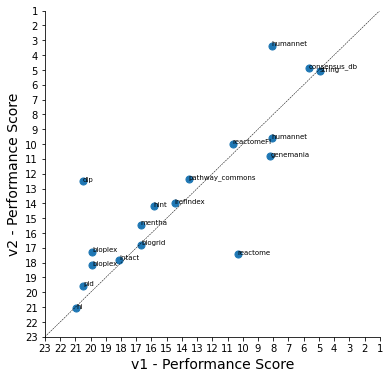

In [ ]:
plot_rank_comparison(disgen_rank_comp, n1=23, n2=25)

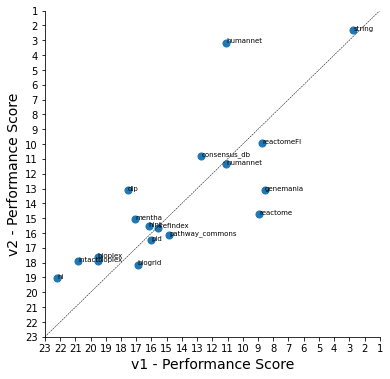

In [ ]:
plot_rank_comparison(gwas_rank_comp, n1=23, n2=25)

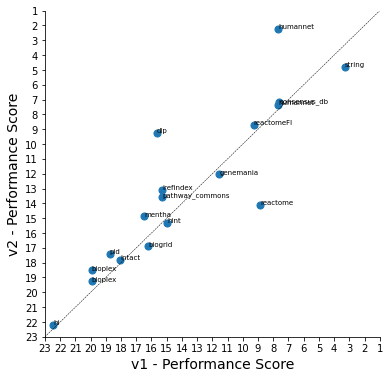

In [ ]:
plot_rank_comparison(disgen_gain_rank_comp, n1=23, n2=25)

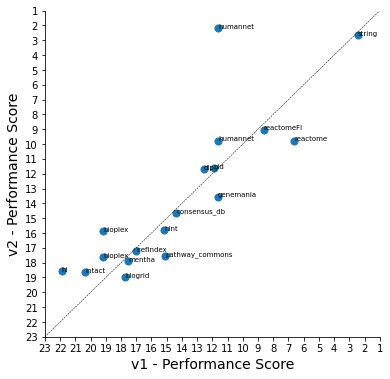

In [ ]:
plot_rank_comparison(gwas_gain_rank_comp, n1=23, n2=25)

### Performance Old vs New

In [ ]:
dp_v2 = disgen_perf.apply(np.mean, axis=0)
dpg_v2 = disgen_gain.apply(np.mean, axis=0)
dp_v1 = disgen_perf_v1.apply(np.mean, axis=0)
dpg_v1 = disgen_gain_v1.apply(np.mean, axis=0)
gp_v2 = gwas_perf.apply(np.mean, axis=0)
gpg_v2 = gwas_gain.apply(np.mean, axis=0)
gp_v1 = gwas_perf_v1.apply(np.mean, axis=0)
gpg_v1 = gwas_gain_v1.apply(np.mean, axis=0)

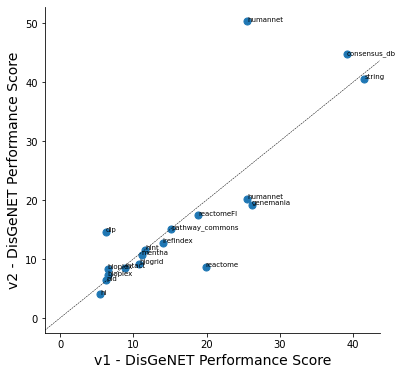

In [ ]:
dp_comp = old_vs_new_comparison(v1_prefixes, v2_prefixes, dp_v1, dp_v2)
plot_performance_comparison(dp_comp, metric="DisGeNET Average Performance Score")

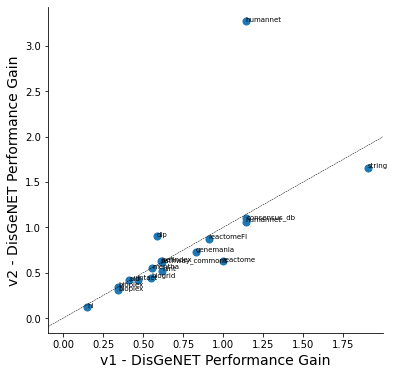

In [ ]:
dpg_comp = old_vs_new_comparison(v1_prefixes, v2_prefixes, dpg_v1, dpg_v2)
plot_performance_comparison(dpg_comp, metric="DisGeNET Average Performance Gain")

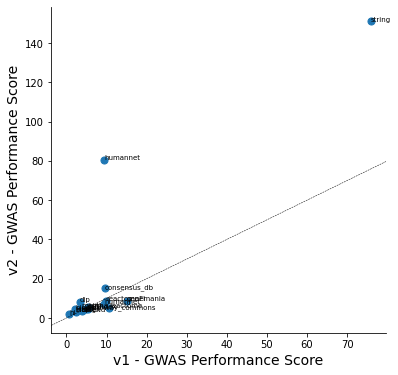

In [ ]:
gp_comp = old_vs_new_comparison(v1_prefixes, v2_prefixes, gp_v1, gp_v2)
plot_performance_comparison(gp_comp, metric="GWAS Performance Score")

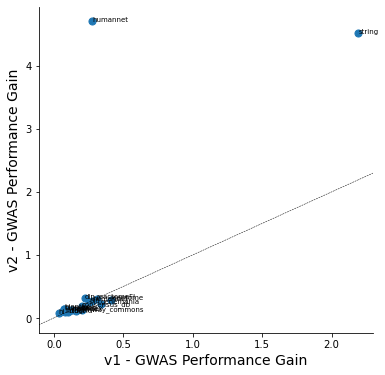

In [ ]:
gpg_comp = old_vs_new_comparison(v1_prefixes, v2_prefixes, gpg_v1, gpg_v2)
plot_performance_comparison(gpg_comp, metric="GWAS Performance Gain")

## Presentation Figures

In [ ]:
prefixes = ["v2_composite_min2", "original_data_sets/pcnet_v1.4", "humannet.v3.xc", "humannet.v3.fn", "original_data_sets/humannet.v1", 
            "consensus_db.v35", "original_data_sets/consensus_db.v32", "giant_90"]


In [ ]:
perf = load_evaluation_files(prefixes, eval_dir, "Performance")
perf = perf.loc[:, prefixes]
gain = load_evaluation_files(prefixes, eval_dir, "Gain")
gain = gain.loc[:, prefixes]

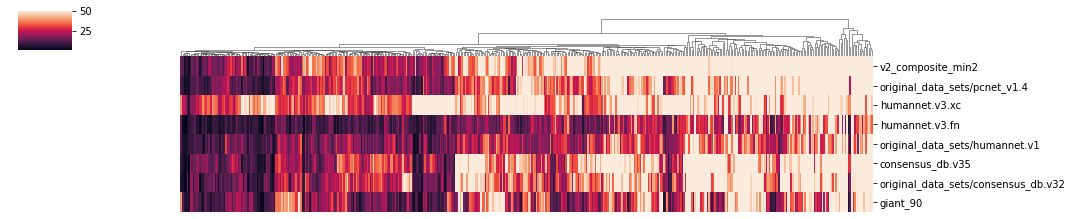

In [ ]:
sns.clustermap(perf.T, row_cluster=False, figsize=(15, 3), xticklabels=False, vmax=50)
plt.savefig("/cellar/users/snwright/Data/Transfer/pcnet/figures/disgen_performance_heatmap_top_networks.png", dpi=600, bbox_inches="tight")

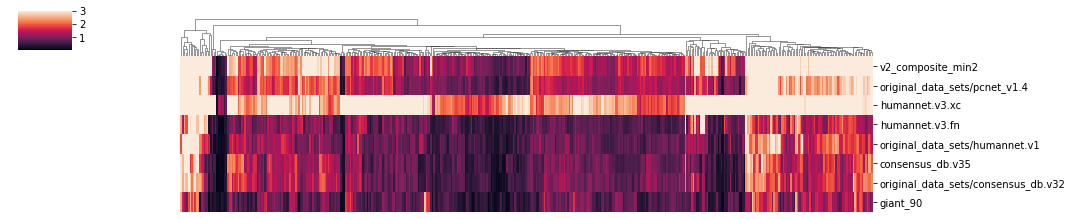

In [ ]:
sns.clustermap(gain.T, row_cluster=False, figsize=(15, 3), xticklabels=False, vmax=3)
plt.savefig("/cellar/users/snwright/Data/Transfer/pcnet/figures/disgen_performance_gain_heatmap_top_networks.png", dpi=600, bbox_inches="tight")

/cellar/users/snwright/anaconda3/envs/pcnet_py3/lib/python3.10/site-packages/seaborn-0.11.2-py3.10.egg/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


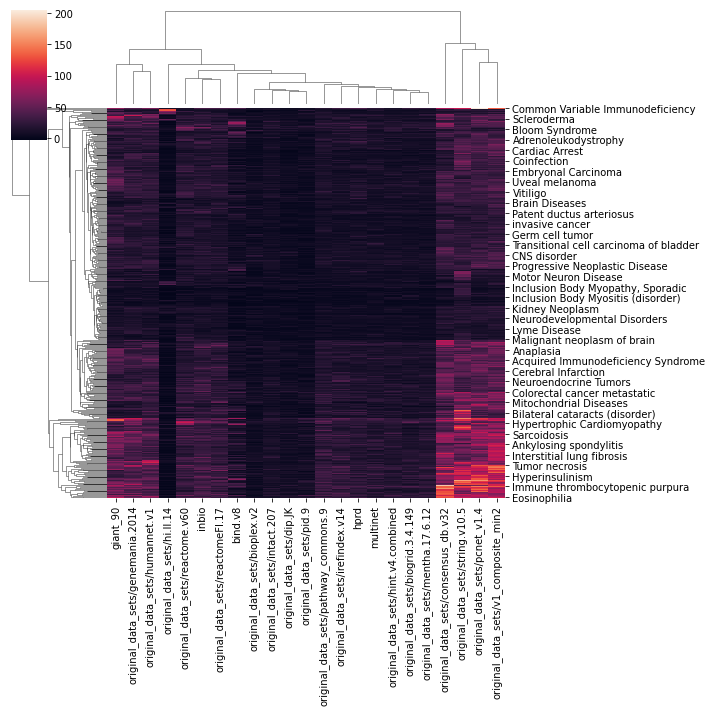

In [ ]:
disgen_perf_v1 = load_evaluation_files(v1_prefixes, eval_dir, "Performance")
disgen_ranks_v1, _ = average_network_rank(disgen_perf_v1)
sns.clustermap(disgen_perf_v1)

In [ ]:
perfg = load_evaluation_files(prefixes, eval_dir, "Performance", geneset="gwas_orig")
perfg = perfg.loc[:, prefixes]
gaing = load_evaluation_files(prefixes, eval_dir, "Gain", geneset="gwas_orig")
gaing = gaing.loc[:, prefixes]

['/cellar/users/snwright/Data/Network_Analysis/Evaluation/Performance/v2_composite_min2.gwas_orig.performance.csv', '/cellar/users/snwright/Data/Network_Analysis/Evaluation/Performance/original_data_sets/pcnet_v1.4.gwas_orig.performance.csv', '/cellar/users/snwright/Data/Network_Analysis/Evaluation/Performance/humannet.v3.xc.gwas_orig.performance.csv', '/cellar/users/snwright/Data/Network_Analysis/Evaluation/Performance/humannet.v3.fn.gwas_orig.performance.csv', '/cellar/users/snwright/Data/Network_Analysis/Evaluation/Performance/original_data_sets/humannet.v1.gwas_orig.performance.csv', '/cellar/users/snwright/Data/Network_Analysis/Evaluation/Performance/consensus_db.v35.gwas_orig.performance.csv', '/cellar/users/snwright/Data/Network_Analysis/Evaluation/Performance/original_data_sets/consensus_db.v32.gwas_orig.performance.csv', '/cellar/users/snwright/Data/Network_Analysis/Evaluation/Performance/giant_90.gwas_orig.performance.csv']
['/cellar/users/snwright/Data/Network_Analysis/Evalu

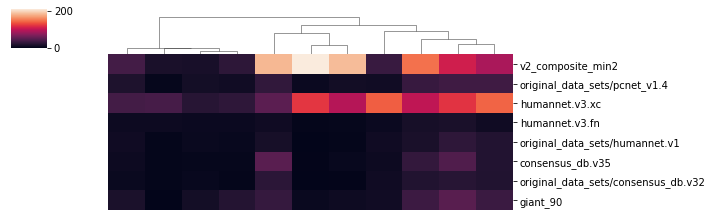

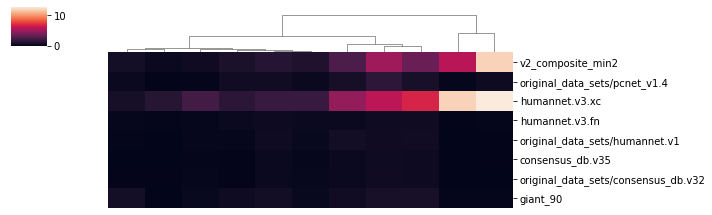

In [ ]:
sns.clustermap(perfg.T, row_cluster=False, figsize=(10, 3), xticklabels=False)
sns.clustermap(gaing.T, row_cluster=False, figsize=(10, 3), xticklabels=False)